# Classifier evaluation

In the last two sessions, we implemented our first prediction models (T05: linear and logistic regression, T06: decision trees) -- hurray! We already separated the dataset features from their class, fed these features to a regression model or decision tree and trained the model to make a prediction, whether a patient is ill or not.

We can say that we model described the existing data to a good extent (if we hadn't restricted the `max_depth` of the tree, our model would yield to a 100% accuracy). But did our algorithm actually "learn" anything? In other words, would our linear/tree model predict the class correctly if we give it a completely new patient and his or her health records? We don't know yet.

We trained and tested our decision tree model's accuracy on the same data for a simplicity reason, but that's not usually the case in real machine learning projects. Usually, we want to create algorithms that generalize beyond the observed data. It makes sense that we could only evaluate the ability of the model to generalize from a data sample using data that it had not seen before.

## Train-Test split

Now we understand that we would want some additional, unseen before data entries to test our prediction model, but where do we get them? Well, meaningful data collection is hard, so why don't we just say from the beginning that we preserve some part of the existing dataset and use it later for evaluation purpose. Sounds good, right?

Splitting your dataset is essential for an unbiased evaluation of prediction performance. In most cases, it’s enough to split your dataset randomly into two subsets:

1.   The *training set* is applied to train, or fit, your model.
2.   The *test set* is needed for an unbiased evaluation of the final model.


In [13]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.model_selection import train_test_split

In [25]:
# Data preparation (from last session)

df = pd.read_csv('data/data_banknote_authentication.txt', names=['Variance', 'Skewness', 'Kurtosis', 'Entropy', 'Class'])

print(df.shape)
print(df.columns)

# separate target (dependent) variable from features (independent variables)
X = df.drop('Class', axis=1).copy()
y = df['Class'].copy()

(1372, 5)
Index(['Variance', 'Skewness', 'Kurtosis', 'Entropy', 'Class'], dtype='object')


**Recap:** If you are curious how these features were extracted from photos of the banknotes, check the [Wavelet transform](https://towardsdatascience.com/what-is-wavelet-and-how-we-use-it-for-data-science-d19427699cef) out. But simply speaking we convert each image into a distribution of its pixels and extract some statistics about the distribution:

*  Variance - measure of variability or spread of the distribution;
*   Skewness - measure of symmetry of a distribution. In normal distributions skewness = 0. Distribution skewed to the right  (a.k.a positive skewed) will have a longer right tail and to the left (negative skew) a longer left tail (longer tails occur because of outliers);
*   Kurtosis - measures how "thick" are the tails of the distribution;
* Entropy - measure of uncertainty.

But don't get confused by the features - that's not the important thing in this exercise.

We also have a fifth column `Class`. That looks like the target, that we want to predict. Indeed, class 1 stands for "genuine banknote" and class 0 for "fake banknote".


### Exercise: Make a training and test data split (see T05)

While training the logistic regression model in T05, we already made a training and test data split. Please apply this step here.

In [68]:
# todo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=16)

### Exercise: Evaluating the model
Now, train a decision tree model on the training data and evaluate it using test data. Obtain a confusion matrix and compute performance metrics.

In [41]:
# todo 
classifier = DecisionTreeClassifier(max_depth = 2)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[210  15]
 [ 29 158]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       225
           1       0.91      0.84      0.88       187

    accuracy                           0.89       412
   macro avg       0.90      0.89      0.89       412
weighted avg       0.89      0.89      0.89       412



### Exercise: Plot a ROC curve and compute AUC

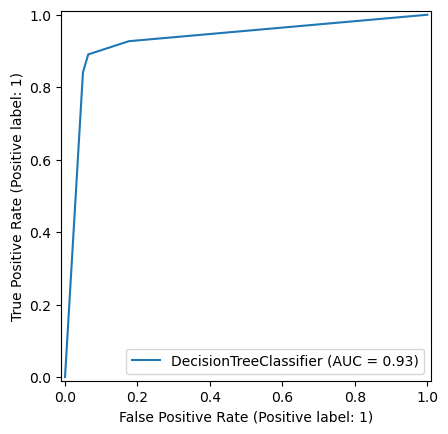

In [53]:
roc_disp = RocCurveDisplay.from_estimator(classifier, X_test, y_test)

# Exercises ML algorithms

We have learned a couple of machine learning algorithms so far. 

1. Implement them here and benchmark their performance using the ROC analysis with standard parameters.
2. Adjust the parameters to improve the performance. Mind the separation of test data.

                 Model  Accuracy  Precision    Recall  F1 Score       MCC  \
0        Random Forest  0.959514   0.978846  0.928832  0.953184  0.918543   
1              XGBoost  0.949798   0.970930  0.914234  0.941729  0.898957   
2             CatBoost  0.965992   0.984674  0.937956  0.960748  0.931635   
3             LightGBM  0.956275   0.980545  0.919708  0.949153  0.912307   
4  Logistic Regression  0.977328   0.957746  0.992701  0.974910  0.954753   

        AUC  
0  0.996819  
1  0.989054  
2  0.998157  
3  0.997180  
4  0.999216  


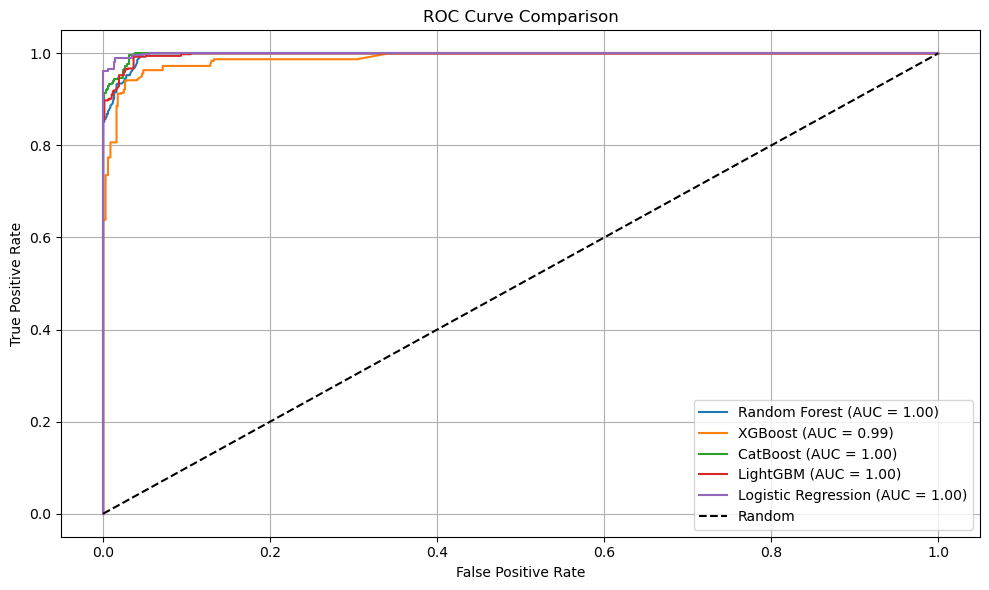

In [70]:
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, roc_auc_score, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier # console: pip install xgboost in case of ModuleNotFoundError
from lightgbm import LGBMClassifier # console: pip install xgboost in case of ModuleNotFoundError
from catboost import CatBoostClassifier


# Standardize for Logistic Regression (optional)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define classifiers
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=16),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=16),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=16),
    'LightGBM': LGBMClassifier(verbose=-1, random_state=16),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=16)
}

# Store results
results = []
roc_data = {}

# Train and evaluate
for name, model in models.items():
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'MCC': mcc,
        'AUC': auc
    })

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_data[name] = (fpr, tpr)

# Show table
results_df = pd.DataFrame(results)
print(results_df)

# Plot ROC curves
plt.figure(figsize=(10, 6))
for name, (fpr, tpr) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, models[name].predict_proba(X_test_scaled if name=="Logistic Regression" else X_test)[:,1]):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
